# Section 0 问题描述与完成项目流程

## 1. 问题描述


<img src="default.png" width="20%"></img>

在该项目中，你将使用强化学习算法，实现一个自动走迷宫机器人。

1. 如上图所示，智能机器人显示在右上角。在我们的迷宫中，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。机器人要尽量避开陷阱、尽快到达目的地。
2. 小车可执行的动作包括：向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`。
3. 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1
4. 我们需要通过修改 `robot.py` 中的代码，来实现一个 Q Learning 机器人，实现上述的目标。

## 2. 完成项目流程

1. 配置环境，使用 `envirnment.yml` 文件配置名为 `robot-env` 的 conda 环境，具体而言，你只需转到当前的目录，在命令行/终端中运行如下代码，稍作等待即可。
```
conda env create -f envirnment.yml
```
安装完毕后，在命令行/终端中运行 `source activate robot-env`（Mac/Linux 系统）或 `activate robot-env`（Windows 系统）激活该环境。

2. 阅读 `main.ipynb` 中的指导完成项目，并根据指导修改对应的代码，生成、观察结果。
3. 导出代码与报告，上传文件，提交审阅并优化。
---

---

# Section 1 算法理解


## 1. 1 强化学习总览

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

---

**问题 1**：请参照如上的定义，描述出 “机器人走迷宫这个问题” 中强化学习五个组成部分对应的实际对象：

- **环境** : 机器人所处的迷宫的物理环境，包括迷宫的道路设置，通道，墙，陷阱，以及对机器人在交互过程中所得到的反馈，比如奖励，惩罚等等
- **状态** : 机器人在迷宫中的状态，实际上描述机器人当前情况的一个抽象概念，它与机器人能否成功学到一个策略息息相关。在本项目中，它是小车所处的迷宫坐标位置，例如 (0,1)、(1,1) 等。如果将状态设定为“处于起点”、“处于陷阱”、“处于终点”等情况，而缺少坐标等量化信息，则会让机器人无法获知所处状态，从而无法做出合理的动作，这样的话根本无法训练到机器人。有了坐标的量化信息，才能通过量化系统来训练到机器人。


- **动作** : 机器人执行的操作，包括有向上走、向下走、向左走、向右走四种动作。 
- **奖励** : 从Sutton的教材中，有如下的定义："On each time step, the environment sends to the reinforcement learning agent a single number called the reward. The agent’s sole objective is to maximize the total reward it receives over the long run. The reward signal thus defines what are the good and bad events for the agent."
即在每一个时间步长里，环境都会给机器人每一个动作或状态指定的一个数字。这个数字是为了让机器人区分正确的动作或陷阱。在本项目中，项目模型的目标就是要让机器人能够在较长时间段内积累到最多的数字奖励。在本项目中，具体的奖励设置如下：

- 撞到墙壁：-10
- 走到终点：50
- 走到陷阱：-30
- 其余情况：-0.1

这样的设置是考虑了项目的目标（即训练机器人走到终点），以及小车在实现目标的过程中，遭遇各种情况的严重程度而给予不同程度的惩罚。在没有走到目标之前，所有的动作都是负值。而走到陷阱为最严重的一种，因此给予-30的惩罚分（奖励）。撞到墙壁严重程度次之，给予-10的惩罚分。走到终点给予50的奖励分。而除此之外的其它动作严重程度很低，给予-0.1的惩罚。

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## 1.2 计算 Q 值 

在我们的项目中，我们要实现基于 Q-Learning 的强化学习算法。Q-Learning 是一个值迭代（Value Iteration）算法。与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。因此，对每个状态值的准确估计，是我们值迭代算法的核心。通常我们会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。

在 Q-Learning 算法中，我们把这个长期奖励记为 Q 值，我们会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，我们考虑执行动作 $a$ 后环境给我们的奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a q(a,s_{t+1})$，$\gamma$ 为折扣因子。

不过一般地，我们使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$



---
<img src="default2.png" width="20%"></img>

**问题 2**：根据已知条件求 $q(s_{t},a)$，在如下模板代码中的空格填入对应的数字即可。


已知：如上图，机器人位于 $s_1$，行动为 `u`，行动获得的奖励与题目的默认设置相同。在 $s_2$ 中执行各动作的 Q 值为：`u`: -24，`r`: -13，`d`: -0.29、`l`: +40，$\gamma$ 取0.9。


$$
\begin{align}
q(s_{t},a) & = R_{t+1} + \gamma \times\max_a q(a,s_{t+1}) \\
 & =(-0.1) + (0.9)*(40) \\
 & =(35.9)
\end{align}
$$


---

## 1.3 如何选择动作

在强化学习中，「探索-利用」问题是非常重要的问题。具体来说，根据上面的定义，我们会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。但是这样做有如下的弊端：
1. 在初步的学习中，我们的 Q 值会不准确，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此我们需要一种办法，来解决如上的问题，增加机器人的探索。由此我们考虑使用 epsilon-greedy 算法，即在小车选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

---

**问题 3**：在如下的代码块中，实现 epsilon-greedy 算法的逻辑，并运行测试代码。

In [1]:
import random

actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 以0.3的概率进行随机选择

def choose_action(epsilon):
    a= random.uniform(0,1)
    if a <epsilon : # 以某一概率
        action = random.choice(actions) # 实现对动作的随机选择
    else: 
        action = max(qline,key=qline.get) # 否则选择具有最大 Q 值的动作
    return a, action
choose_action(epsilon)

(0.7783826980347774, 'l')

---

---

# Section 2 代码实现

## 2.1. `Maze` 类理解

我们首先引入了迷宫类 `Maze`，这是一个非常强大的函数，它能够根据你的要求随机创建一个迷宫，或者根据指定的文件，读入一个迷宫地图信息。

1. 使用 `Maze("file_name")` 根据指定文件创建迷宫，或者使用 `Maze(maze_size=(height,width))` 来随机生成一个迷宫。
2. 使用 `trap_number` 参数，在创建迷宫的时候，设定迷宫中陷阱的数量。
3. 直接键入迷宫变量的名字按回车，展示迷宫图像（如 `g=Maze("xx.txt")`，那么直接输入 `g` 即可。
4. 建议生成的迷宫尺寸，长在 6~12 之间，宽在 10～12 之间。

---

**问题 4**：在如下的代码块中，创建你的迷宫并展示。

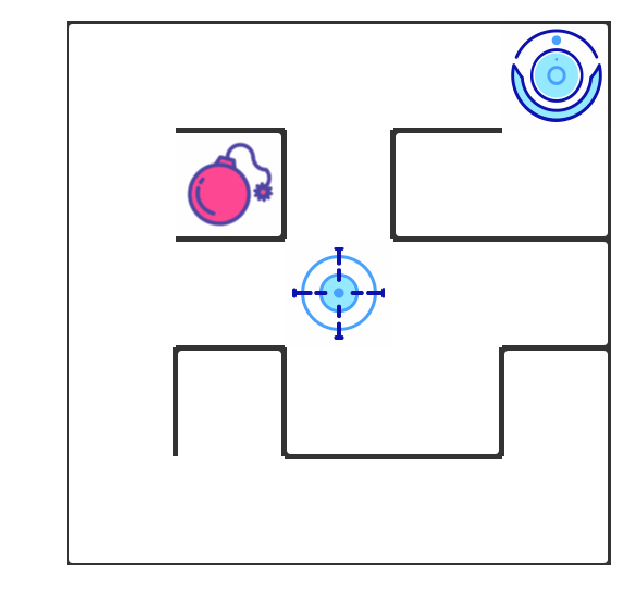

Maze of size (5, 5)

In [2]:
from Maze import Maze

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## todo: 创建迷宫并展示
g = Maze(maze_size=(5,5), trap_number=1)
g

---

你可能已经注意到，在迷宫中我们已经默认放置了一个机器人。实际上，我们为迷宫配置了相应的 API，来帮助机器人的移动与感知。其中你随后会使用的两个 API 为 `maze.sense_robot()` 及 `maze.move_robot()`。

1. `maze.sense_robot()` 为一个无参数的函数，输出机器人在迷宫中目前的位置。
2. `maze.move_robot(direction)` 对输入的移动方向，移动机器人，并返回对应动作的奖励值。

---

**问题 5**：随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。

[-10.0, -10.0, -0.1, -10.0, -0.1, -0.1, -10.0, -0.1, -0.1, -0.1]
(0, 0)


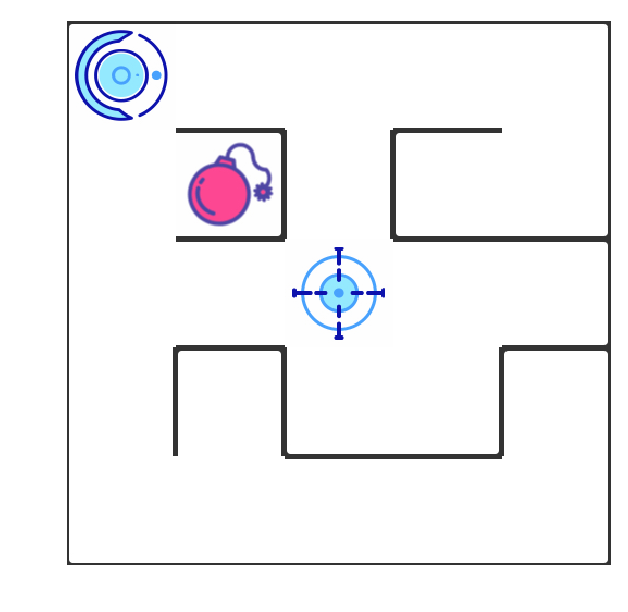

Maze of size (5, 5)


In [3]:
from Maze import Maze
rewards = []

## 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    rewards.append(g.move_robot(random.choice(actions)))
print(rewards)

## 输出机器人最后的位置
print(g.sense_robot())

## 打印迷宫，观察机器人位置
print(g)

## 2.2. `Robot` 类实现

`Robot` 类是我们需要重点实现的部分。在这个类中，我们需要实现诸多功能，以使得我们成功实现一个强化学习智能体。总体来说，之前我们是人为地在环境中移动了机器人，但是现在通过实现 `Robot` 这个类，机器人将会自己移动。通过实现学习函数，`Robot` 类将会学习到如何选择最优的动作，并且更新强化学习中对应的参数。

首先 `Robot` 有多个输入，其中 `alpha=0.5, gamma=0.9, epsilon0=0.5` 表征强化学习相关的各个参数的默认值，这些在之前你已经了解到，`Maze` 应为机器人所在迷宫对象。

随后观察 `Robot.update` 函数，它指明了在每次执行动作时，`Robot` 需要执行的程序。按照这些程序，各个函数的功能也就明了了。

最后你需要实现 `Robot.py` 代码中的8段代码，他们都在代码中以 `#TODO` 进行标注，你能轻松地找到他们。

---

**问题 6**：实现 `Robot.py` 中的8段代码，并运行如下代码检查效果（记得将 `maze` 变量修改为你创建迷宫的变量名）。



('r', -0.1)


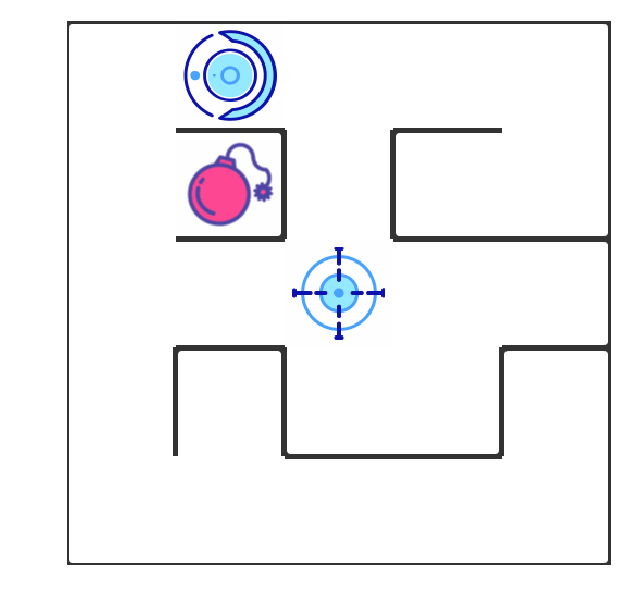

Maze of size (5, 5)

In [4]:
from Robot import Robot
robot = Robot(g) # 记得将 maze 变量修改为你创建迷宫的变量名
robot.set_status(learning=True,testing=False)
print(robot.update())

g

---

## 2.3 用 `Runner` 类训练 Robot

在实现了上述内容之后，我们就可以开始对我们 `Robot` 进行训练并调参了。我们为你准备了又一个非常棒的类 `Runner`，来实现整个训练过程及可视化。使用如下的代码，你可以成功对机器人进行训练。并且你会在当前文件夹中生成一个名为 `filename` 的视频，记录了整个训练的过程。通过观察该视频，你能够发现训练过程中的问题，并且优化你的代码及参数。

---

**问题 7**：尝试利用下列代码训练机器人，并进行调参。可选的参数包括：

- 训练参数
    - 训练次数 `epoch`
- 机器人参数：
    - `epsilon0` (epsilon 初值)
    - `epsilon`衰减（可以是线性、指数衰减，可以调整衰减的速度），你需要在 Robot.py 中调整
    - `alpha`
    - `gamma`
- 迷宫参数:
    - 迷宫大小
    - 迷宫中陷阱的数量

In [5]:
#解决tqdm和cv2包不识别的问题
import sys
sys.path.append('/Users/apple/Anaconda3/envs/robot-env/Lib/site-packages')

In [66]:
## 可选的参数：
epoch = 40

epsilon0 = 0.5
alpha = 0.5
gamma = 0.9

maze_size = (8,10)
trap_number = 2

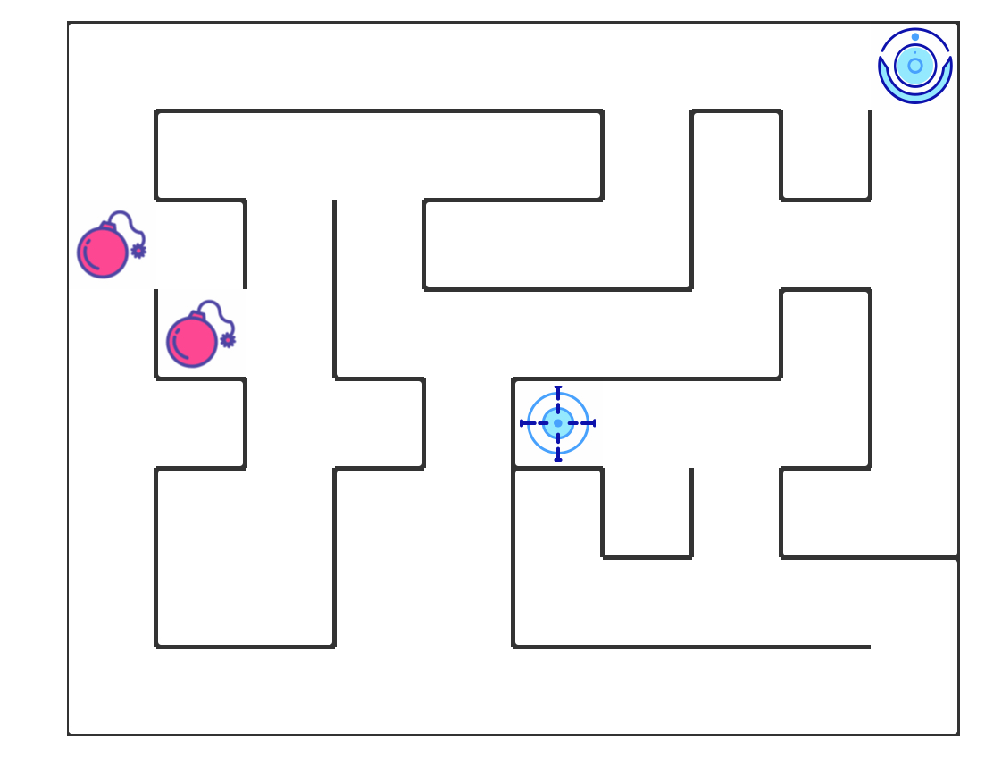

Maze of size (8, 10)


In [67]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)

g.sense_robot()
print(g)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)

In [ ]:
#runner.generate_movie(filename = "final1.mp4") # 你可以注释该行代码，加快运行速度，不过你就无法观察到视频了。

---

使用 `runner.plot_results()` 函数，能够打印机器人在训练过程中的一些参数信息。

- Success Times 代表机器人在训练过程中成功的累计次数，这应当是一个累积递增的图像。
- Accumulated Rewards 代表机器人在每次训练 epoch 中，获得的累积奖励的值，这应当是一个逐步递增的图像。
- Running Times per Epoch 代表在每次训练 epoch 中，小车训练的次数（到达终点就会停止该 epoch 转入下次训练），这应当是一个逐步递减的图像。

---

**问题 8**：使用 `runner.plot_results()` 输出训练结果，根据该结果对你的机器人进行分析。

- 指出你选用的参数如何，选用参数的原因。
- 建议你比较不同参数下机器人的训练的情况。
- 训练的结果是否满意，有何改进的计划。

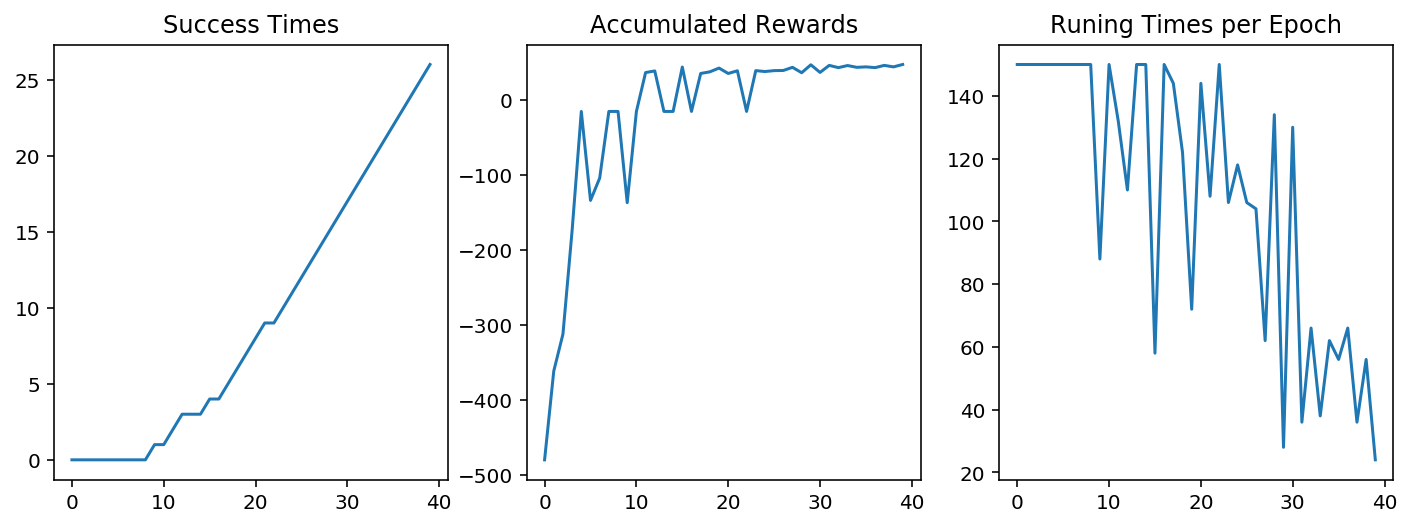

In [68]:
runner.plot_results()

(回答区)

1.选用的参数，选用参数的原因：

- 按照Q-learning的设计原则，在选择动作时，机器人前期需多探索环境，了解环境之后，后期则更多地使用最优策略，希望快速达到目标。因此对于$\epsilon$-贪婪算法中的$\epsilon$的衰减函数最好是前期能衰减较慢，后期加速衰减，而且在设定的epoch数值范围里，必须最终衰减趋近于零。

- 步长参数$\alpha$必须满足$0<\alpha\leq1$，$\alpha$值越大，则机器人更侧重于最近探索的历史rewards，学习速度越快；$\alpha$越小，则机器人更新动作值函数时，会考虑更多的历史rewards，让学习更慢。如果$\alpha$过大，可能导致无法收敛。因此为了保证能收敛，$\alpha$需要足够小。但在能保证收敛的前提下，$\alpha$值可以微调的大一些，让学习的更快。

- 折扣参数$\gamma$在[0,1]的区间之内，值越大，则更重视过往的学习；值越小，则更关心当前的学习。

- epoch的数值，很大程度取决于迷宫的大小和复杂程度。迷宫越大，越复杂，则需要更多的epoch，让机器人最终较熟练和快速的完成目标。

- 对三个参数的初始设置：
 - epsilon0 = 0.5 （让机器人刚开始时，更多地环境进行探索，能有50%的概率随机选择动作，50%的概率按最大值选择动作）
 - alpha = 0.5 （在学习速度和收敛上取得平衡）
 - gamma = 0.9 （折扣率的一个常规初值）

- 迷宫大小（8,10）,是为了让视频上的参数能够展示出来，以及runner的三个图中能较清楚地看出趋势。

- 迷宫的trap number = 2是通过多次试错得到的。我发现当trap number设置过多（$\geq4$时），机器人有较多概率直接堵死，而无法完成任务。

- epoch=40的选择，是通过试错和迭代，通过画图和观看视频获得的。对我设置的迷宫大小和trap number，大部分情况下，epoch>40之后，plot results中三张图基本趋于稳定，尤其是第二张和第三张subplots。第二张稳定维持在50，第三张的running time则在快速下降之后，稳定趋近于20左右。


2.本项目中最关键的，决定训练好坏和是否收敛的关键点在于$\epsilon$的衰减函数。在衰减函数的选择上，首先是基于第一条已经提到的原则：“$\epsilon$的衰减函数最好是前期能衰减较慢，后期加速衰减，而且在设定的epoch数值范围里，必须最终衰减趋近于零。”
在这个原则的基础上，我查看了较多的资料，主要是查看了OpenAI-Gym-Taxi-v2项目中得分前6名的算法和衰减函数，发现他们主要采用$$self.epsilon = self.epsilon * self.decay$$的方法(http://www.puzzlr.org/sarsa-expected-sarsa-and-q-learning-on-the-openai-taxi-environment/)
（https://github.com/kotogasy/OpenAI-Gym-Taxi-v2/blob/master/openai-gym-taxi-v2.ipynb）
(https://medium.com/@thiagoricieri/really-simple-way-to-write-a-decay-function-in-python-667ce7db2f6c)。
因为被证明有效且项目环境类似，因此也成为本项目的衰减函数。

当然我也考虑了其它的一些衰减函数，并微调一些参数，并作图进行了比较。代码和比较图见下部分。
- 其中，x1和x2均为我的衰减函数，只是衰减常数不同。为了让衰减不那么快速，我选择了0.99。
- x3和x4为另外一种，这种函数无视epsilon的初始值，均从1开始衰减，根据参数的微调，则衰减速度不同。x4衰减较慢，在500个时间步内，无法衰减到零。
- x5则是课件中提到的1/t的方法，则衰减最为迅速。


3.从runner plot_results来看，针对当前的随机迷宫，
- 第一张图中，机器人在前8个epoch的训练中中均没有成功，随后的训练成功的累计次数基本线性快速增加，在40个epoch中，累积成功了28次，符合预期。
- 第二张图中，机器人在前10次epoch中，快速获得的累积奖励的值，从-480到-20左右。随后缓慢从-20平稳增加到50，并趋于稳定。
- 第三张图中，机器人在每个训练周期所需的时长，从最初的160逐步递减到20左右，这是训练的必然趋势，符合预期。

总体来说，我对训练还是比较满意，毕竟是经过多次的试错反复获得的结果，同时也结合了OpenAI-Gym-Taxi-v2项目排名靠前的经验。至于改进的部分，有以下建议：
- 衰减函数仍然是最关键的优化训练的部分，可以做更多的参数微调，才获得更优的训练和打分。

- 本项目只用了q-learning (即Sarsamax)的方法, 还可以通过加入Sarsa和Expected Sarsa的算法，比较三者，优中选优。这个工作量较大。

- 本项目最大的问题在于，runner.py随机生成迷宫，每次跑此代码后，生成的迷宫都不相同，而且有些迷宫一生成根本无解，或者路不通，或者被炸弹堵死，或者起始位置就在目的地等等，所以需要把迷宫打印出来，首先人工预检查到底有没有解。同时，也造成了很难在同一个迷宫上，比较各参数调整下的改进情况，同时审阅者看到的迷宫和我选择的那个迷宫也不一定相同，即本次运行的情况不可复制。这个bug可以通过改进代码来解决。


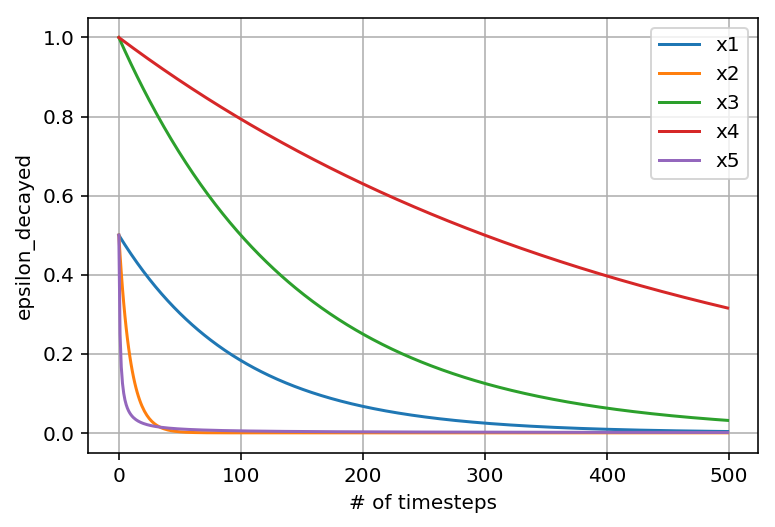

In [73]:
# 作图比较epsilon衰减函数
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#for i in range(500):
#   epsilon = epsilon*0.99
x1=np.arange(500)
y1=epsilon0*0.99**x1

x2=np.arange(500)
y2=epsilon0*0.9**x1

x3=np.arange(500)
y3=epsilon0**(x3/100)

x4=np.arange(500)
y4=epsilon0**(x4/300)

x5=np.arange(500)
y5=epsilon0/(x5+1)

plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,x5,y5)
plt.xlabel('# of timesteps')
plt.ylabel('epsilon_decayed')
plt.grid()
plt.legend(labels=['x1','x2','x3','x4','x5'])

---

**问题 9：** 请将如下的文件打包，提交文件给审阅者。

- `robot.py`
- `robot_maze.ipynb`
- 由 `robot_maze.ipynb` 导出的 `robot_maze.html`

### 参考资料


https://stackoverflow.com/questions/37818409/strange-html-doctype-error-when-trying-to-run-python-script-from-bash

https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o

https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.random_sample.html#numpy.random.random_sample

https://docs.python.org/3/library/random.html

https://github.com/openai/gym/wiki/Leaderboard

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

https://github.com/kotogasy/OpenAI-Gym-Taxi-v2/blob/master/openai-gym-taxi-v2.ipynb

https://github.com/jo4x962k7JL/OpenAI-Gym-Taxi-v2/blob/master/Taxi-v2.ipynb

http://www.puzzlr.org/sarsa-expected-sarsa-and-q-learning-on-the-openai-taxi-environment/

https://stackoverflow.com/questions/14091636/get-dict-key-by-max-value

https://stackoverflow.com/questions/51022464/message-poping-up-while-installing-python-packages

https://stackoverflow.com/questions/19876079/opencv-cannot-find-module-cv2

https://stackoverflow.com/questions/51233491/unresolved-reference-cv2-inside-cv2-cv2-cv2

https://anaconda.org/conda-forge/opencv

https://stackoverflow.com/questions/47529792/no-module-named-tqdm

https://stackoverflow.com/questions/23119413/how-do-i-install-python-opencv-through-conda
